In [176]:
import model as m 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [177]:
#Select disease
d = "Measles"

#monthly data
monthly_data = pd.read_csv( d +'_data_processed.csv')
time_date = monthly_data.iloc[:,0]

#cumulative monthly data
ecdc_disease_noTime = monthly_data.drop("Time", axis=1)
cumulative_data = ecdc_disease_noTime.apply(lambda x: np.cumsum(x))

In [178]:
print(time_date[0])
print(time_date[len(time_date)-1])

years_run = int(time_date[len(time_date)-1][0:4]) - int(time_date[0][0:4]) +1


print(years_run, "--> tmax")


1999-01
2019-12
21 --> tmax


### Extracting birth and death rates for age groups:

* Death rates: *death_rate_7_age_groups_1982-2018.csv*: 
$$ d_i = \frac{\text{number of death people who are in i-th age group}}{\text{population in i-th age group}}$$
* Births: *Crude_birth_rate_1938-2018.csv*, unit is birth number per 1000 population
* Population: *population_7_age_groups_1982-2018.csv*

In [179]:
##### Births
Births = pd.read_csv("Data//Crude_birth_rate_1938-2018.csv")

#Select from year 1999 to 2018
Births_years = Births.iloc[0:(2018-1999+1),:]

#Selecting 3rd column for UK data
Births_years_UK = Births_years.iloc[:,2] 

Births_UK =  Births_years_UK.to_numpy()
#We shall reverse the order to go from 1999 to 2018

Births_UK = list(reversed(Births_UK))

print(Births_UK)

[11.9, 11.5, 11.3, 11.3, 11.7, 11.9, 12.0, 12.3, 12.6, 12.8, 12.7, 12.9, 12.8, 12.8, 12.1, 12.0, 11.9, 11.8, 11.4, 11.0]


In [180]:
#### Deaths
Deaths = pd.read_csv("Data//death_rate_7_age_groups_1982-2018.csv")

#exclude last row (no total)
Deaths = Deaths.iloc[0:7,:]

#Selecting columns for years 1999-2018
Deaths_years = Deaths.iloc[:,np.where(Deaths.columns=="1999")[0][0]:np.where(Deaths.columns=="2018")[0][0]+1]

print(Deaths_years)
#Deaths_years.iloc[:,0].to_numpy()

       1999      2000      2001      2002      2003      2004      2005  \
0  0.005762  0.005588  0.005570  0.005346  0.005421  0.005194  0.005126   
1  0.000278  0.000236  0.000233  0.000239  0.000244  0.000231  0.000218   
2  0.000118  0.000117  0.000120  0.000109  0.000111  0.000100  0.000096   
3  0.000151  0.000135  0.000146  0.000142  0.000140  0.000124  0.000137   
4  0.000434  0.000423  0.000422  0.000408  0.000380  0.000376  0.000377   
5  0.000651  0.000653  0.000621  0.000624  0.000603  0.000572  0.000533   
6  0.017067  0.016406  0.016096  0.016069  0.016072  0.015269  0.015122   

       2006      2007      2008      2009      2010      2011      2012  \
0  0.005091  0.004938  0.004751  0.004698  0.004425  0.004371  0.004102   
1  0.000228  0.000227  0.000210  0.000182  0.000182  0.000181  0.000164   
2  0.000102  0.000096  0.000107  0.000093  0.000094  0.000083  0.000089   
3  0.000131  0.000127  0.000101  0.000108  0.000099  0.000089  0.000095   
4  0.000366  0.000351  0

In [181]:
#### Population
Pops = pd.read_csv("Data//population_7_age_groups_1982-2018.csv")

#Just need last row

Pops_tot = Pops.iloc[7,np.where(Deaths.columns=="1999")[0][0]:np.where(Deaths.columns=="2018")[0][0]+1]

#print(Pops_tot)

Pops_tot[0]

58684300

### Still have to include a real Contact matrix from Polymod

In [182]:
para = m.ModelParams(
    age_strucure=[0,1, 5, 10, 15, 20, 30],  #age cuts
    B=Births_UK[0]*1000/Pops_tot[0],  #births rate per capita
    V=np.zeros([7]),
    d=list(Deaths_years.iloc[:,0].to_numpy()),  #death rate
    gamma=(1.0/14.0*365.0*1e-3)*np.ones([7]),
    C=np.eye(7),
    N=Pops_tot[0]
)

In [183]:
beta=np.eye(7)*1.2

In [184]:
mdl = m.SIRVModel(para, lambda t: beta)

In [194]:
out_year, t_year = mdl.run(np.hstack([0.95*(1./6)*np.ones(7), 0.05*(1./6)*np.ones(7), np.zeros(7*2)]), 
                 t_max = 1,method="RK45", eval_per_year=24)

In [195]:
out = out_year
t = t_year

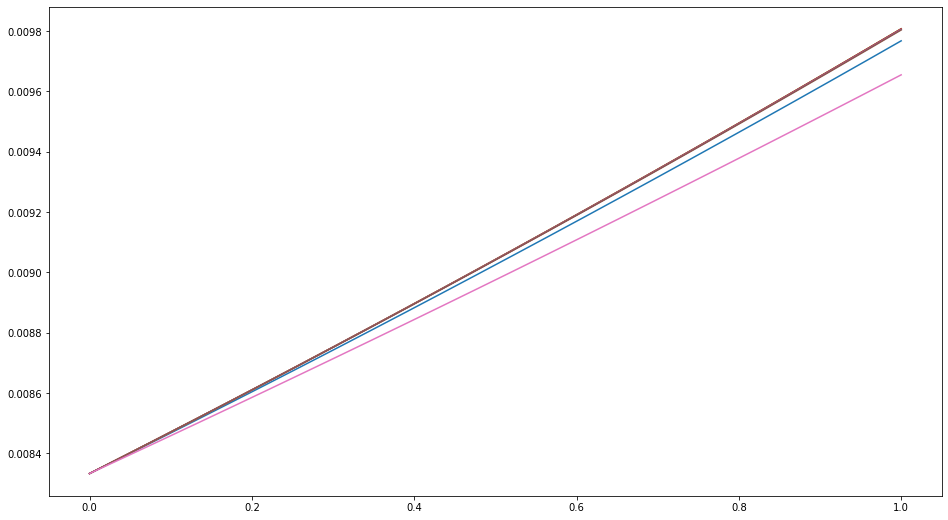

In [196]:
out[7:(7*2),:]
plt.figure(figsize=(16,9))
plt.plot(t, np.transpose(out[7:(7*2),:]))

In [197]:
for run_t in np.arange(1, years_run-1):
    beta=np.eye(7)*1.2
    para.B = Births_UK[run_t]*1000/Pops_tot[run_t]
    para.d = list(Deaths_years.iloc[:,run_t].to_numpy())
    para.N = Pops_tot[run_t]
    mdl = m.SIRVModel(para, lambda t: beta)
    
    out_year, t_year = mdl.run(out_year[:,23], t_max = 1,method="RK45", eval_per_year=24)
    
    out = np.concatenate((out, out_year[:,1:24]), axis = 1)
    
    t_year = t_year+run_t
    t = np.concatenate((t, t_year[1:24]))
    

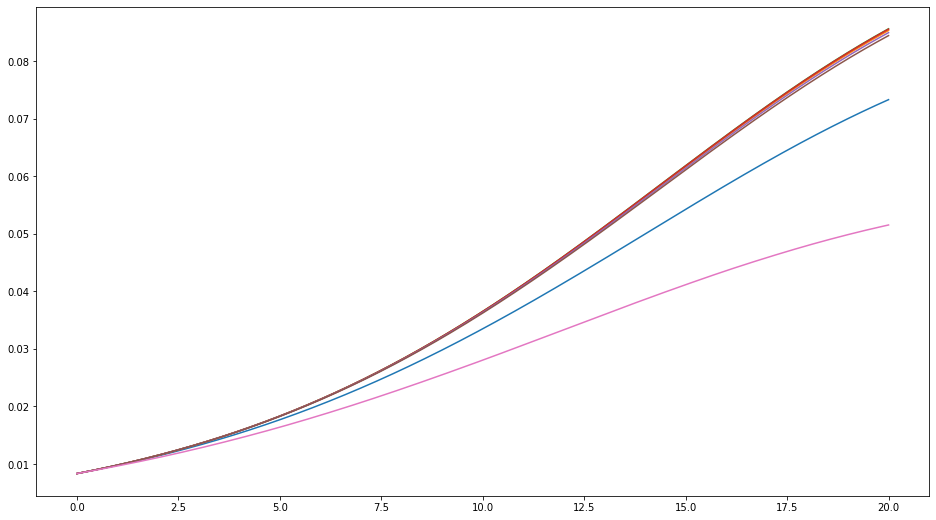

In [199]:
out[7:(7*2),:]
plt.figure(figsize=(16,9))
plt.plot(t, np.transpose(out[7:(7*2),:]))